# 1. Introdução

Esse trabalho tem como objetivo testar alguns modelos preditivos para criarmos uma série temporal de previsão dos valores futuros de fechamento do índice IBOVESPA.

# 2. Objetivo

# 3. Premissas

Atingir uma acuracidade acima de 70%.

# 4. Desenvolvimento

### Imports realizados

In [1]:
import pandas as pd
from prophet import Prophet
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
import yfinance as yf

c:\Users\Sergio Velloso\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Carregamento dos Dados

In [2]:
symbol= '^BVSP'
start_date = '2000-01-01'
end_date = '2024-01-20'

# Use a função download para obter os dados
df = yf.download(symbol, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [3]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,17098.0,17408.0,16719.0,16930.0,16930.0,0
2000-01-04,16908.0,16908.0,15851.0,15851.0,15851.0,0
2000-01-05,15871.0,16302.0,15350.0,16245.0,16245.0,0
2000-01-06,16237.0,16499.0,15977.0,16107.0,16107.0,0
2000-01-07,16125.0,16449.0,16125.0,16309.0,16309.0,0


In [4]:
# Verificando a estrutura do dataframe

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5954 entries, 2000-01-03 to 2024-01-19
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       5954 non-null   float64
 1   High       5954 non-null   float64
 2   Low        5954 non-null   float64
 3   Close      5954 non-null   float64
 4   Adj Close  5954 non-null   float64
 5   Volume     5954 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 325.6 KB


In [5]:
# Resetando o index e convertendo para datetime

df = df.reset_index('Date')
df['Date'] = pd.to_datetime(df['Date']) 


In [6]:
df_ibovespa = df.sort_values(by='Date', ascending=True)

### Visualizando a série do índice IBOVESPA

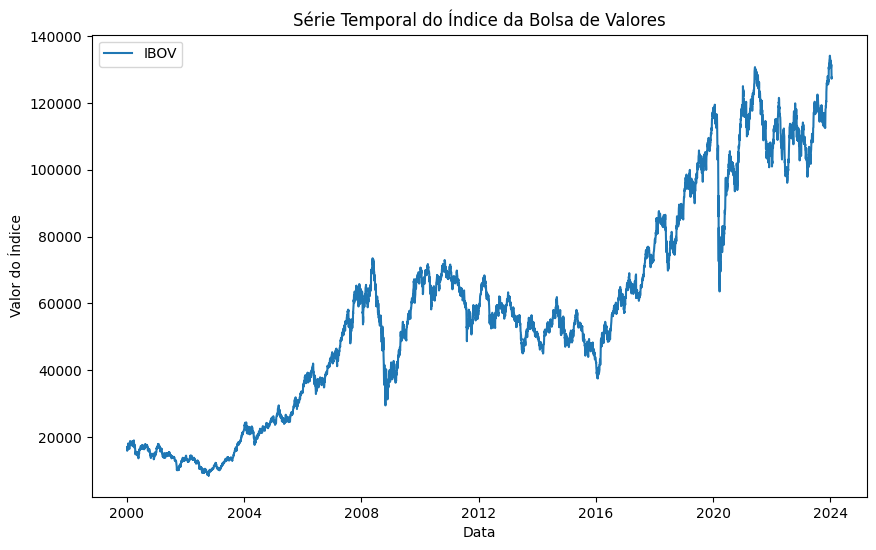

In [7]:
# Plotando a série temporal

plt.rcParams['figure.figsize'] = (10, 6)
plt.plot(df_ibovespa['Date'], df_ibovespa['Close'], label = 'IBOV')
plt.title('Série Temporal do Índice da Bolsa de Valores')
plt.xlabel('Data')
plt.ylabel('Valor do Índice')
plt.legend(loc='best')
plt.show()

Analisando rapidamente é possível vermos nos anos de 2009 e 2020 as duas principais quedas abruptas no indice, que representam, respectivamente, a **crise de 2009 e a pandemia global causada pela COVID-19**. Como pode ser visto destacado na imagem abaixo:

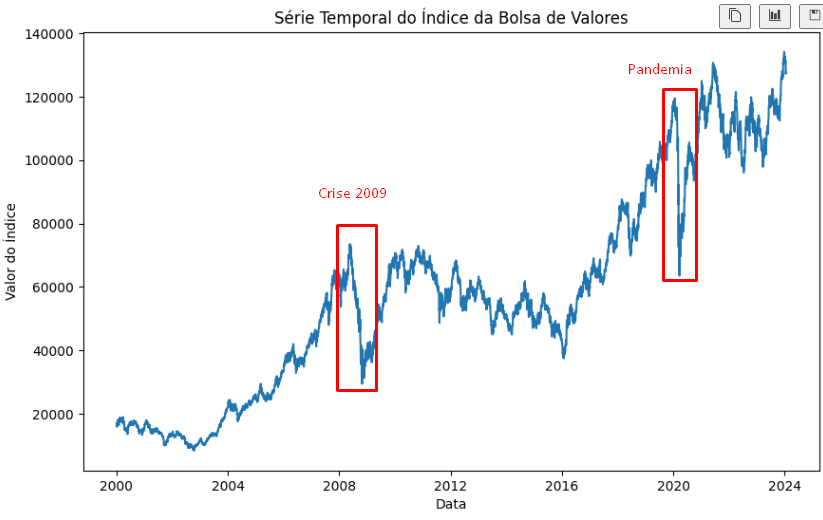

### Análise Exploratória dos dados

Iremos primeiramente decompor a série temporal para analisar a **Tendência, Sazonalidade e Ruído**. 

Para isso utilizaremos a biblioteca Statsmodel, e essa informação será crucial na escolha do modelo ideal para realizar a predição.

C:\Users\Sergio Velloso\AppData\Local\Temp\ipykernel_22628\2973951508.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_eda = df_eda.asfreq('D').fillna(method='ffill')


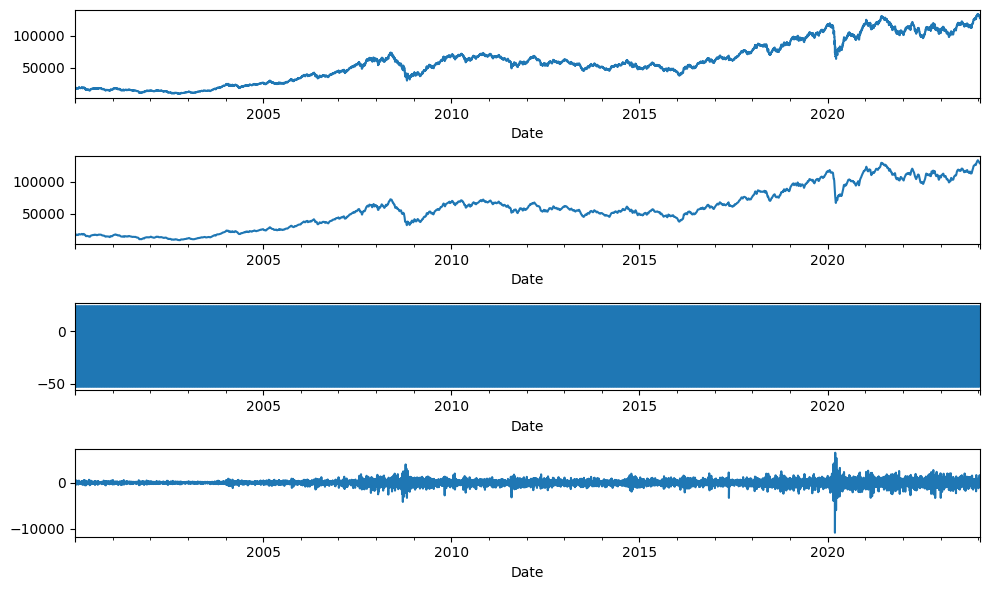

In [8]:
# Criando uma nova view para o dataframe original não ser comprometido com a análise
df_eda = df_ibovespa.drop(columns=['Open', 'High', 'Low', 'Volume', 'Adj Close']).set_index('Date')

# Preenchendo os dias faltantes (FDS + Feriados)
df_eda = df_eda.asfreq('D').fillna(method='ffill')


# Decompondo a série temporal
resultados = seasonal_decompose(df_eda)
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize= (10,6))
resultados.observed.plot(ax=ax1)
resultados.trend.plot(ax=ax2)
resultados.seasonal.plot(ax=ax3)
resultados.resid.plot(ax=ax4)

plt.tight_layout()

Analisando a decomposição da série temporal, podemos observar que:

> **Tendência:** Embora haja bastante variabilidade, é possível observar que a tendência é de alta.

> **Sazonalidade:** O gráfico nos mostra que não existe uma sazonalidade clara no comportamento do índice.

> **Ruído:** Percebmos que os maiores ruídos foram causados nas duas quedas abruptas mencionadas anteriormente.


Analisamos os últimos dois anos para entender melhor as variações no mercado e comparar com a análise dos especialistas do mercado.

In [9]:
df_atual = df_eda[-730:]
df_atual

,Close
Date,
2022-01-20,109102.0
2022-01-21,108942.0
2022-01-22,108942.0
2022-01-23,108942.0
2022-01-24,107752.0
...,...
2024-01-15,131521.0
2024-01-16,129294.0
2024-01-17,128524.0


In [10]:
data_min = df_atual.index.min()
data_max = df_atual.index.max()

print(f'Estaremos analisando os últimos 730 dias da nossa base, que inicia-se no dia {data_min} e finaliza-se no dia {data_max}')

Estaremos analisando os últimos 730 dias da nossa base, que inicia-se no dia 2022-01-20 00:00:00 e finaliza-se no dia 2024-01-19 00:00:00


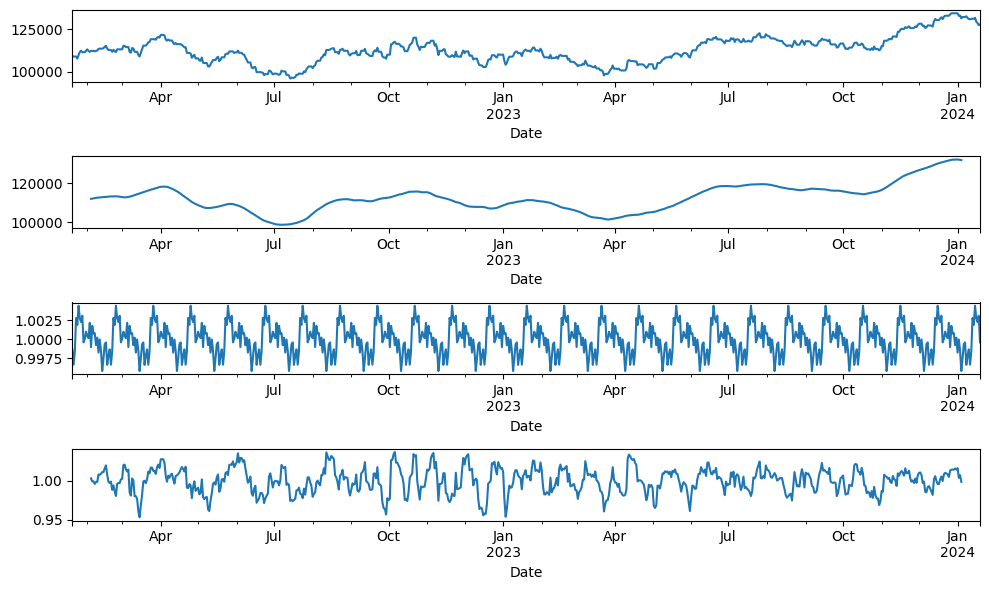

In [17]:
# Decompondo a série temporal
resultados = seasonal_decompose(df_atual, model='multiplicative', period=30)
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize= (10,6))
resultados.observed.plot(ax=ax1)
resultados.trend.plot(ax=ax2)
resultados.seasonal.plot(ax=ax3)
resultados.resid.plot(ax=ax4)

plt.tight_layout()

Analisando a decomposição da nova série temporal, podemos observar que:

> **Tendência:**  Permance sendo de alta.

> **Sazonalidade:**  Aparentemente existe uma ciclicidade, mas acreditamos que possa ser causada pelo método *"asfreq('D').fillna(method='ffill')"* que utilizamos para fazer o preenchimento dos feriados e finais de semana

> **Ruído:** Percebemos que retirando o período das quedas abruptas, muda bastante.

Repetiremos o processo utilizando o método de interpolação para o preenchimento das datas

In [12]:
df_atual2 = df_ibovespa.drop(columns=['Open', 'High', 'Low', 'Volume', 'Adj Close']).set_index('Date').asfreq('D').interpolate(method='linear')[-730:]

data_min2 = df_atual2.index.min()
data_max2 = df_atual2.index.max()

print(f'Estaremos analisando os últimos 730 dias da nossa base, que inicia-se no dia {data_min2} e finaliza-se no dia {data_max2}')

Estaremos analisando os últimos 730 dias da nossa base, que inicia-se no dia 2022-01-20 00:00:00 e finaliza-se no dia 2024-01-19 00:00:00


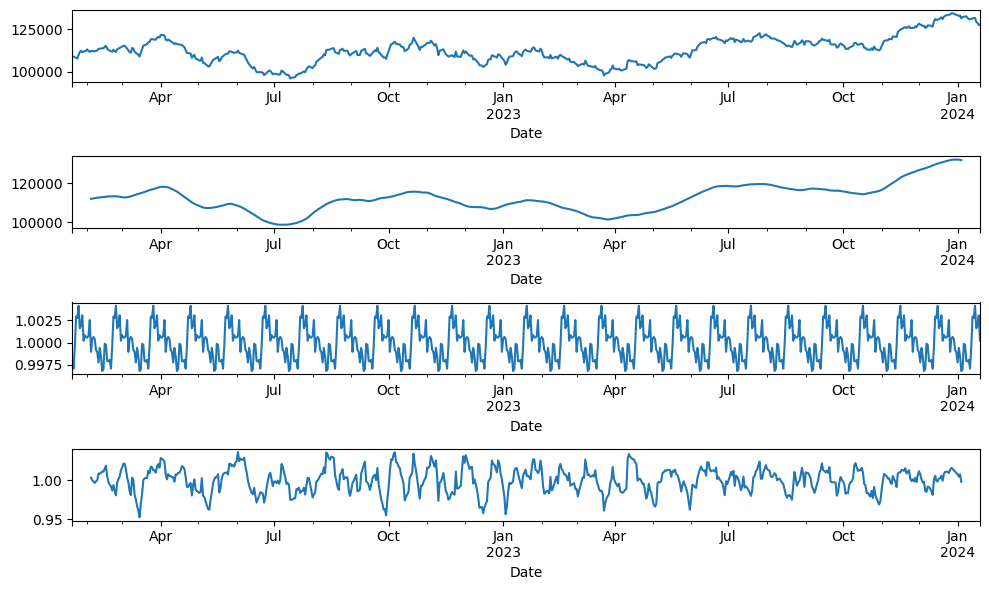

In [13]:
# Decompondo a série temporal
resultados = seasonal_decompose(df_atual2, model='multiplicative', period=30)
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize= (10,6))
resultados.observed.plot(ax=ax1)
resultados.trend.plot(ax=ax2)
resultados.seasonal.plot(ax=ax3)
resultados.resid.plot(ax=ax4)

plt.tight_layout()

Analisando a decomposição da série temporal utilizando o método de interpolação, podemos observar que:

Não houveram modificações tão significativas na decomposição.

Como último método, utilizaremos a decomposição sem inferir valores.

In [14]:
# Como último método, utilizaremos a decomposição sem inferir valores.

df_atual3 = df_ibovespa.drop(columns=['Open', 'High', 'Low', 'Volume', 'Adj Close']).set_index('Date')[-730:]

data_min3 = df_atual3.index.min()
data_max3 = df_atual3.index.max()

print(f'Estaremos analisando os últimos 730 dias da nossa base, que inicia-se no dia {data_min3} e finaliza-se no dia {data_max3}')

Estaremos analisando os últimos 730 dias da nossa base, que inicia-se no dia 2021-02-17 00:00:00 e finaliza-se no dia 2024-01-19 00:00:00


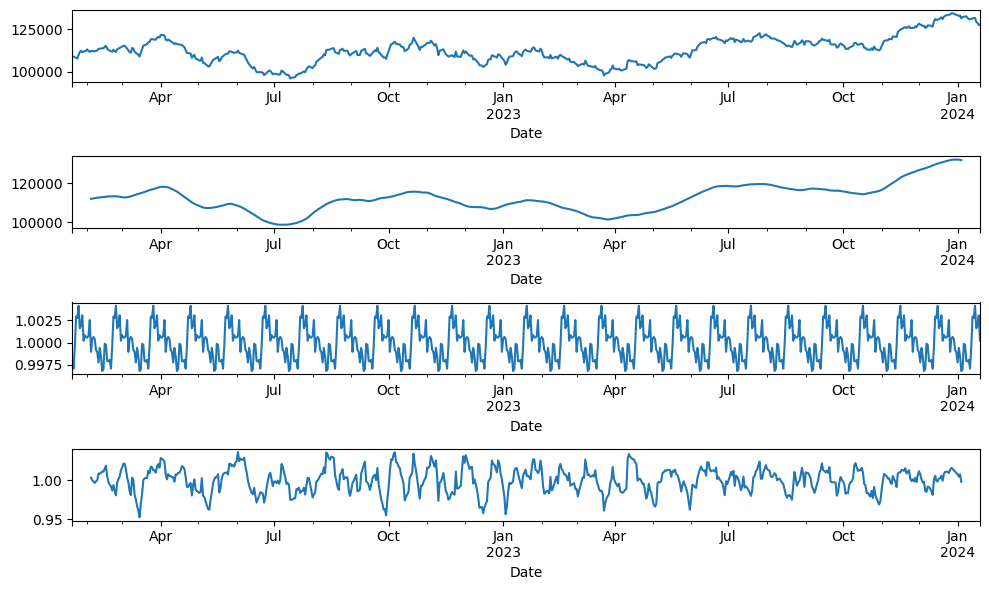

In [15]:
import statsmodels.api as sm

# Decompondo a série temporal com o tsa
resultados = sm.tsa.seasonal_decompose(df_atual2, model='multiplicative',  period=30)
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize= (10,6))
resultados.observed.plot(ax=ax1)
resultados.trend.plot(ax=ax2)
resultados.seasonal.plot(ax=ax3)
resultados.resid.plot(ax=ax4)

plt.tight_layout()

Mesmo retirando os valores inputados "forçadamente" o comportamento permaneceu. Portanto assumiremos que existe sazonalidade, mas é muito impactada pelos ruídos, o que pro fechamento de um índice de bolsa de valores é complicado.

**Seguiremos com a análise exploratória sem inputar valores no entanto utilizando a base inteira para análise.** Para isso, resgataremos o nosso df_eda e não utilizaremos nenhum método de "fill" (preenchimento), usando também o statsmodels.tsa.seasonal.

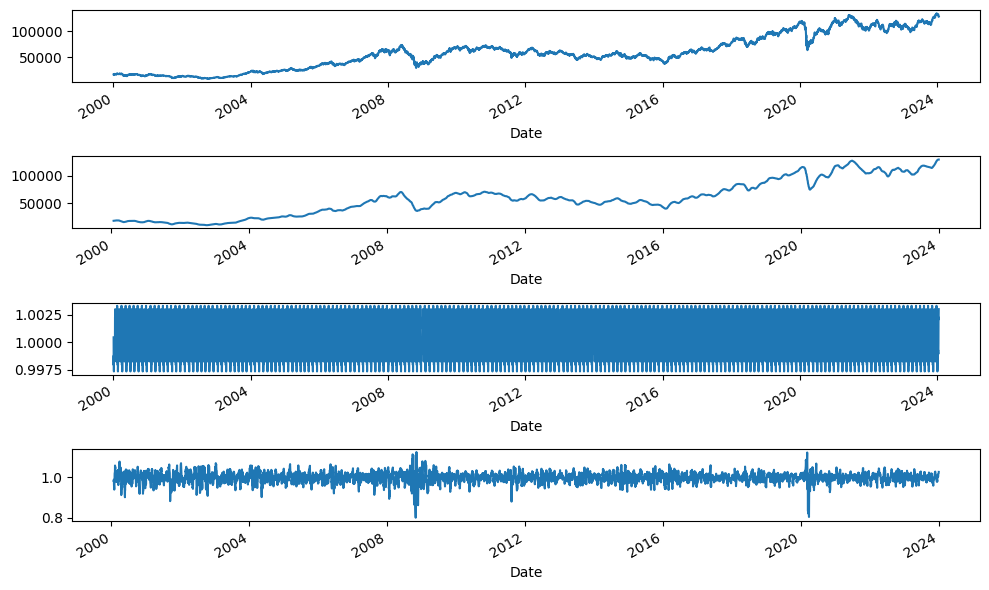

In [21]:
# Criando uma nova view para o dataframe original não ser comprometido com a análise
df_eda_2 = df_ibovespa.drop(columns=['Open', 'High', 'Low', 'Volume', 'Adj Close']).set_index('Date')

# Decompondo a série temporal
resultados = sm.tsa.seasonal_decompose(df_eda_2, model='multiplicative',  period=30)
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize= (10,6))
resultados.observed.plot(ax=ax1)
resultados.trend.plot(ax=ax2)
resultados.seasonal.plot(ax=ax3)
resultados.resid.plot(ax=ax4)

plt.tight_layout()

# COLOCAR ANÁLISES SOBRE O INDICE 

### Desenvolvendo o Modelo de Predição

Começaremos pelo modelo clássico de **Média Móvel.** Vamos utilizar esta técnica para um N de 5 dias, que seria o período de 1 semana da bolsa de valores.

In [22]:
df = pd.DataFrame(df[['Close','Date']])
df.set_index('Date', inplace=True)


,Close
Date,
2000-01-03,16930.0
2000-01-04,15851.0
2000-01-05,16245.0
2000-01-06,16107.0
2000-01-07,16309.0
...,...
2024-01-15,131521.0
2024-01-16,129294.0
2024-01-17,128524.0


In [24]:
df['MA_window_5'] = df['Close'].rolling(5).mean().shift() 

In [25]:
df.head(10) # Os primeiros 5 valores ficarão nulos.

,Close,MA_window_5
Date,,
2000-01-03,16930.0,NaN
2000-01-04,15851.0,NaN
2000-01-05,16245.0,NaN
2000-01-06,16107.0,NaN
2000-01-07,16309.0,NaN
2000-01-10,17022.0,16288.4
2000-01-11,16573.0,16306.8
2000-01-12,16617.0,16451.2
2000-01-13,17298.0,16525.6


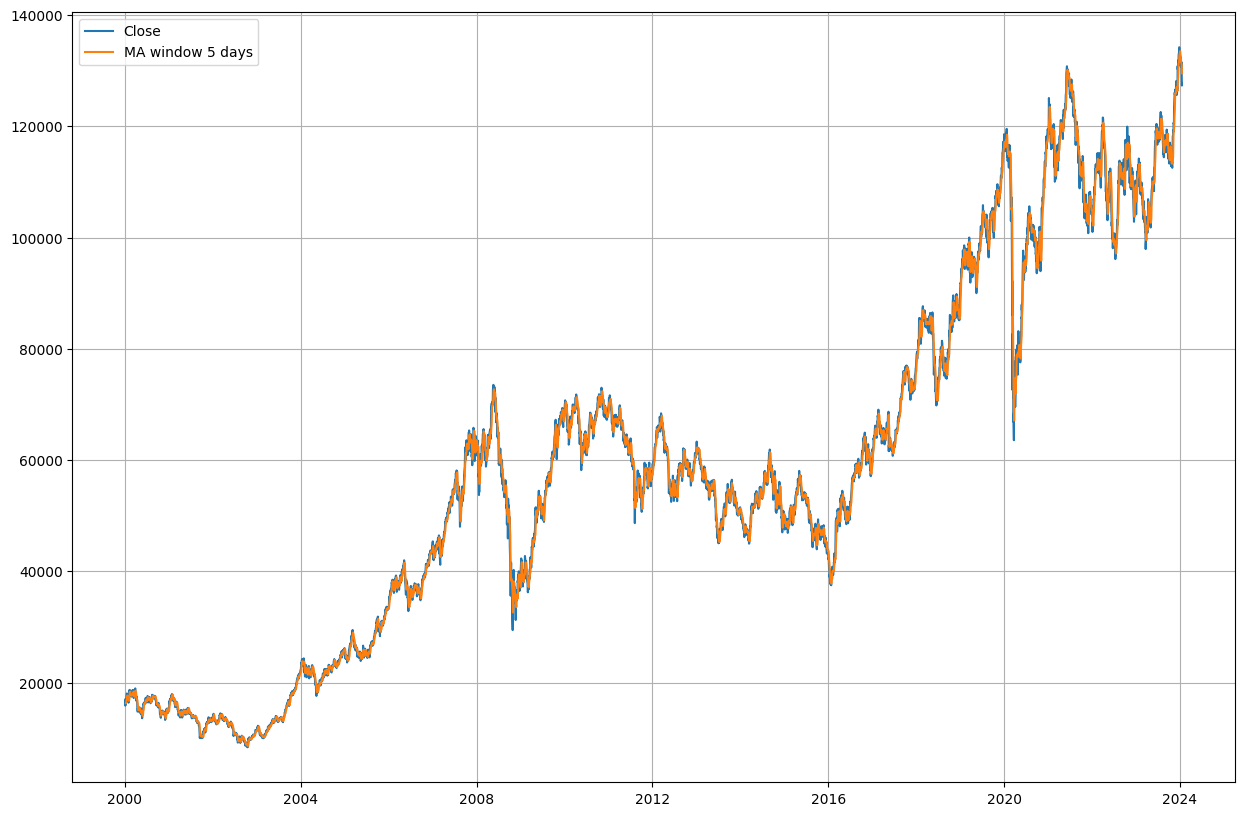

In [30]:
plt.figure(figsize=(15,10))
plt.grid(True)
plt.plot(df['Close'], label='Close')
plt.plot(df['MA_window_5'], label='MA window 5 days')
plt.legend(loc='best')
plt.show()

Reduzimos a base para verificar o mesmo modelo para apenas o último ano. 

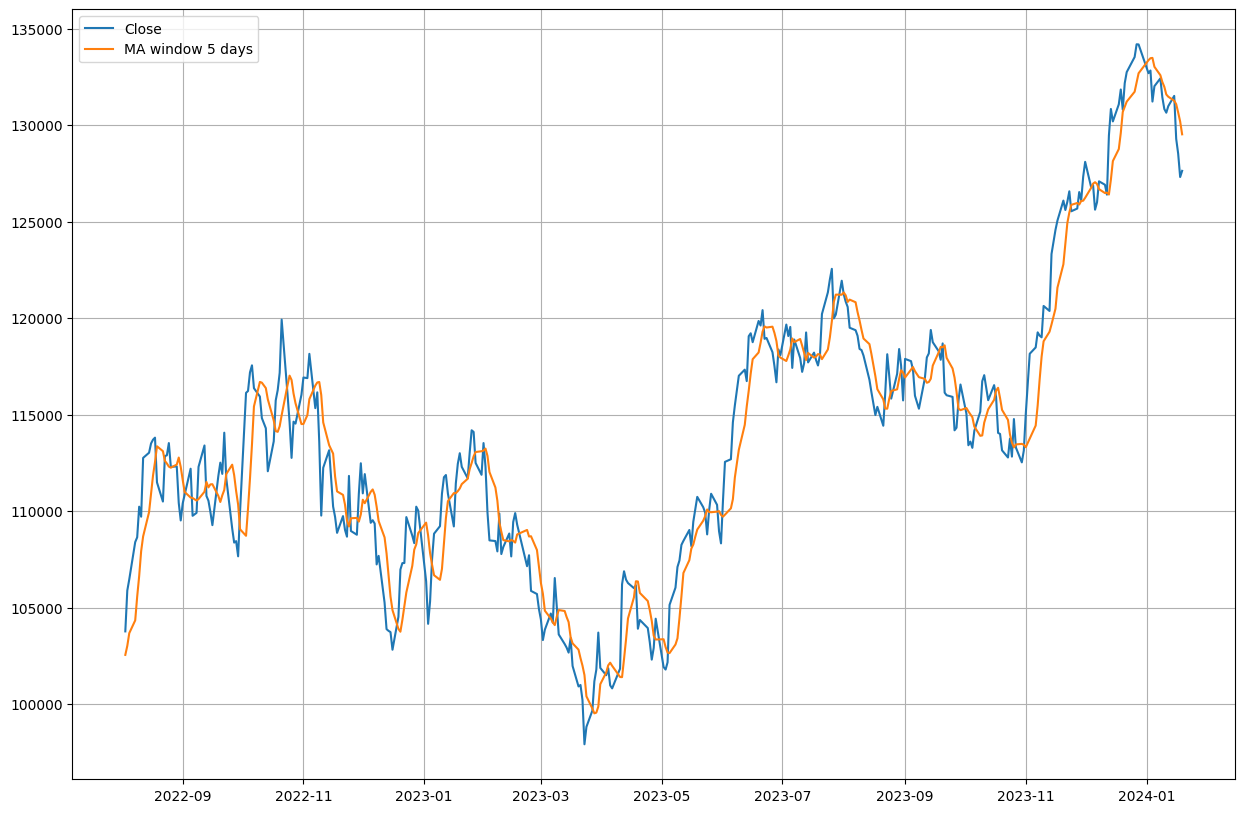

In [31]:
dias = 365

plt.figure(figsize=(15,10))
plt.grid(True)
plt.plot(df['Close'][-dias:], label='Close')
plt.plot(df['MA_window_5'][-dias:], label='MA window 5 days')
plt.legend(loc='best')
plt.show()

Construindo o modelo

In [33]:
# Preechendo com NaN os valores da coluna de MA_window_5_forward_5

df['MA_window_5_forward_5'] = np.NaN 

In [34]:
def make_window(window_size, start_point):
    return [start_point+x for x in range(window_size)] 

In [35]:
window_size = 5
forward_days = 5

# Iteração sobre a série temporal com uma janela deslizante
for index in range(window_size, len(df), forward_days):

    # Iteração para calcular a média móvel ponderada
    for i in range(0, forward_days):
        # Verifica se o índice atual está dentro dos limites da série temporal
        if index + i >= len(df):
            break

        # Criando duas janelas:
        # 1. Uma janela para a média móvel ('window_close')
        # 2. Uma janela para a série temporal original ('window_MA')
        window_close = make_window(window_size - i, index + i - window_size)
        window_MA = make_window(i, index)

        # Calculando a média móvel ponderada
        mean = pd.concat([df['Close'].iloc[window_close], df['MA_window_5_forward_5'].iloc[window_MA]]).mean(axis=0)

        # Atualizando o DataFrame com a média móvel ponderada
        df.iat[index + i, df.columns.get_loc('MA_window_5_forward_5')] = mean


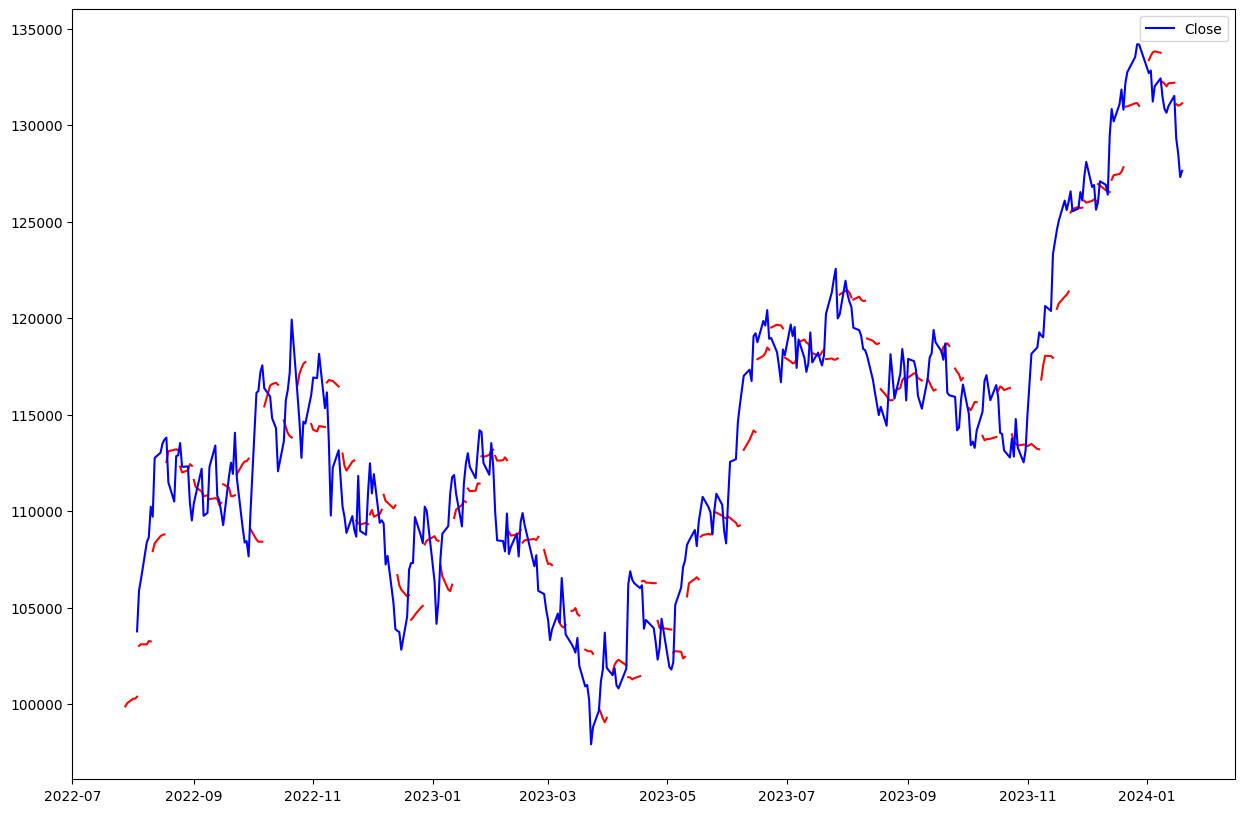

In [36]:
plt.figure(figsize = (15,10))

size = len(df)-dias - (len(df)-dias)%forward_days

for index in range(size, len(df), forward_days):
    plt.plot(df['MA_window_5_forward_5'][index:index+forward_days], color='r')

plt.plot(df['Close'][-dias:], color='b', label='Close')
plt.legend(loc='best')
plt.show()

Com a análise das retas vermelhas, verificamos que o algoritmo não previu com margem de erro aceitável. 

Para escolher o modelo ideal, faremos o teste da estacionariedade.